In [37]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.9/site-packages/')
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Custom code
from coordination.audio.audio import TrialAudio
from coordination.component.speech.vocalics_component import SegmentationMethod, VocalicsComponent
from coordination.entity.trial import Trial
from coordination.inference.discrete_coordination import DiscreteCoordinationInferenceFromVocalics
from coordination.inference.truncated_gaussian_coordination_blending import TruncatedGaussianCoordinationBlendingInference
from coordination.inference.logistic_coordination import LogisticCoordinationInferenceFromVocalics
from coordination.inference.beta_coordination import BetaCoordinationInferenceFromVocalics
from coordination.inference.gaussian_coordination_blending_latent_vocalics import GaussianCoordinationBlendingInferenceLatentVocalics
from coordination.plot.coordination import add_discrete_coordination_bar
from coordination.report.coordination_change_report import CoordinationChangeReport

# Trial 745

We use post processed trial data. To generate this data, execute the script `coordination/scripts/parse_and_save_single_metadata_file.py`.

In [39]:
# Constants
NUM_TIME_STEPS = 17 * 60 #(17 minutes of mission in seconds)
M = int(NUM_TIME_STEPS/2) # We assume coordination in the second half of the period is constant
NUM_FEATURES = 2 # Pitch and Intensity

# Common parameters
MEAN_PRIOR_VOCALICS = np.zeros(NUM_FEATURES)
STD_PRIOR_VOCALICS = np.ones(NUM_FEATURES)
STD_COORDINATED_VOCALICS = np.ones(NUM_FEATURES)
STD_OBSERVED_VOCALICS = np.ones(NUM_FEATURES) * 0.5
ANTIPHASE_FUNCTION = lambda x, s: -x if s == 0 else x
EITHER_PHASE_FUNCTION = lambda x, s: np.abs(x)

# Parameters of the discrete model
P_COORDINATION_TRANSITION = 0.1 # Coordination changes with small probability
P_COORDINATION = 0 # The process starts with no coordination
STD_UNCOORDINATED_VOCALICS = np.ones(NUM_FEATURES)

# Parameters of the Gaussian model
MEAN_COORDINATION_PRIOR = 0; STD_COORDINATION_PRIOR = 1E-16 # The process starts with no coordination
STD_COORDINATION_DRIFT = 0.05 # Coordination drifts by a little

# Parameters of the Beta model
A0 = 1E-16; B0 = 1E16 # The process starts with no coordination

## Vocalic Features

Utterance starting at 2022-07-07T23:04:39.766166+00:00 and ending at 2022-07-07T23:04:41.066166+00:00 is LONG and has flat vocalics. Text: go to B5
Utterance starting at 2022-07-07T23:19:06.107500+00:00 and ending at 2022-07-07T23:19:06.407500+00:00 is SHORT and has flat vocalics. Text:  that's it
Utterance starting at 2022-07-07T23:03:58.351499+00:00 and ending at 2022-07-07T23:04:03.251500+00:00 is LONG and has flat vocalics. Text:  yeah we have either already have you really far away from Sun setting you could stick together this time I think there'll be much better
Utterance starting at 2022-07-07T23:04:22.851499+00:00 and ending at 2022-07-07T23:04:23.351499+00:00 is SHORT and has flat vocalics. Text:  all right
Utterance starting at 2022-07-07T23:05:53.151499+00:00 and ending at 2022-07-07T23:05:55.351499+00:00 is LONG and has flat vocalics. Text:  yep I am are you open the door 3
Utterance starting at 2022-07-07T23:06:51.051500+00:00 and ending at 2022-07-07T23:06:53.351499+00:0

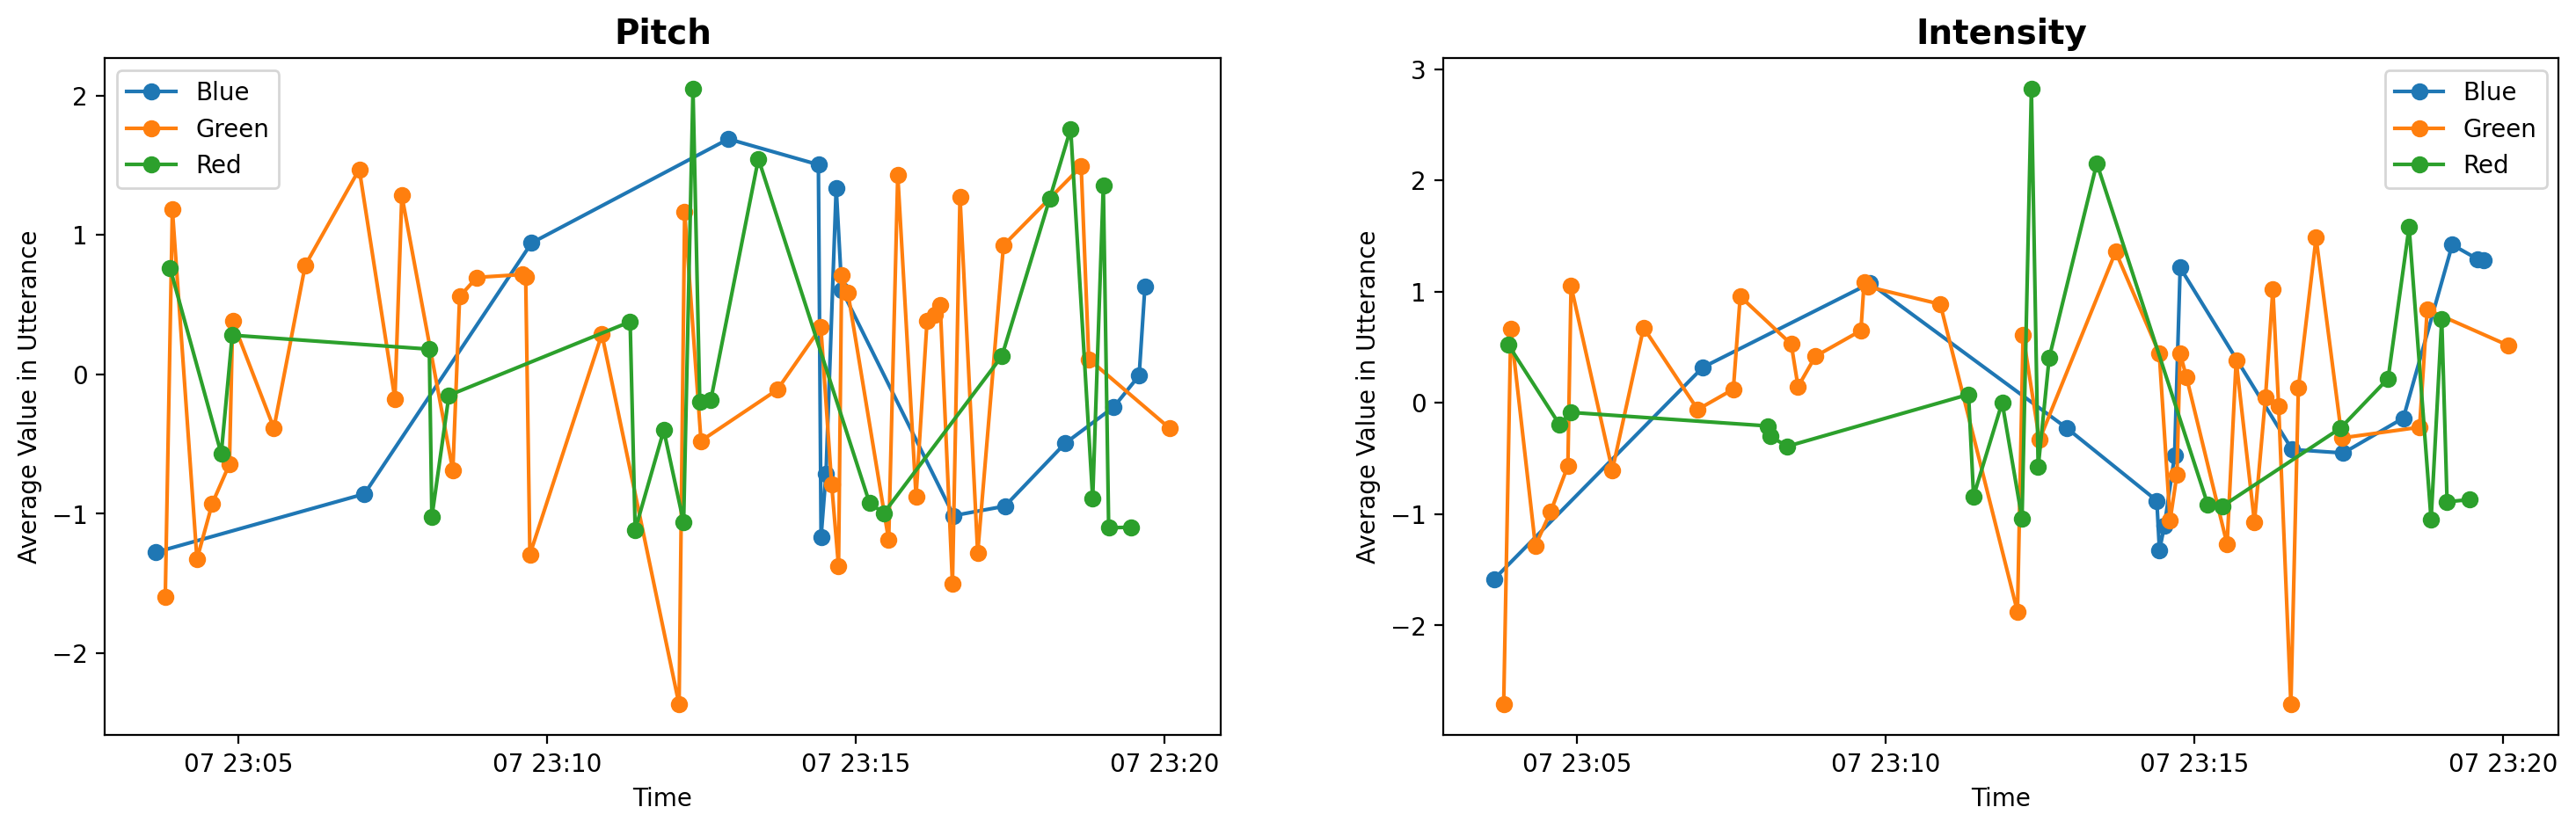

In [55]:
trial = Trial.from_directory("../data/study-3_2022/tomcat_agent/trials/T000822/")
vocalics_component = VocalicsComponent.from_vocalics(trial.vocalics, 
                                                     segmentation_method=SegmentationMethod.KEEP_ALL)

vocalic_series = vocalics_component.sparse_series(NUM_TIME_STEPS, trial.metadata.mission_start)
vocalic_series.normalize_per_subject()

fig, axs = plt.subplots(1, 2, figsize=(18,5))
vocalics_component.plot_features(axs=axs, 
                                 num_time_steps=1020, 
                                 mission_start=trial.metadata.mission_start,
                                 timestamp_as_index=True, 
                                 normalize=True)

## Discrete Coordination Inference

### Phase Coordination

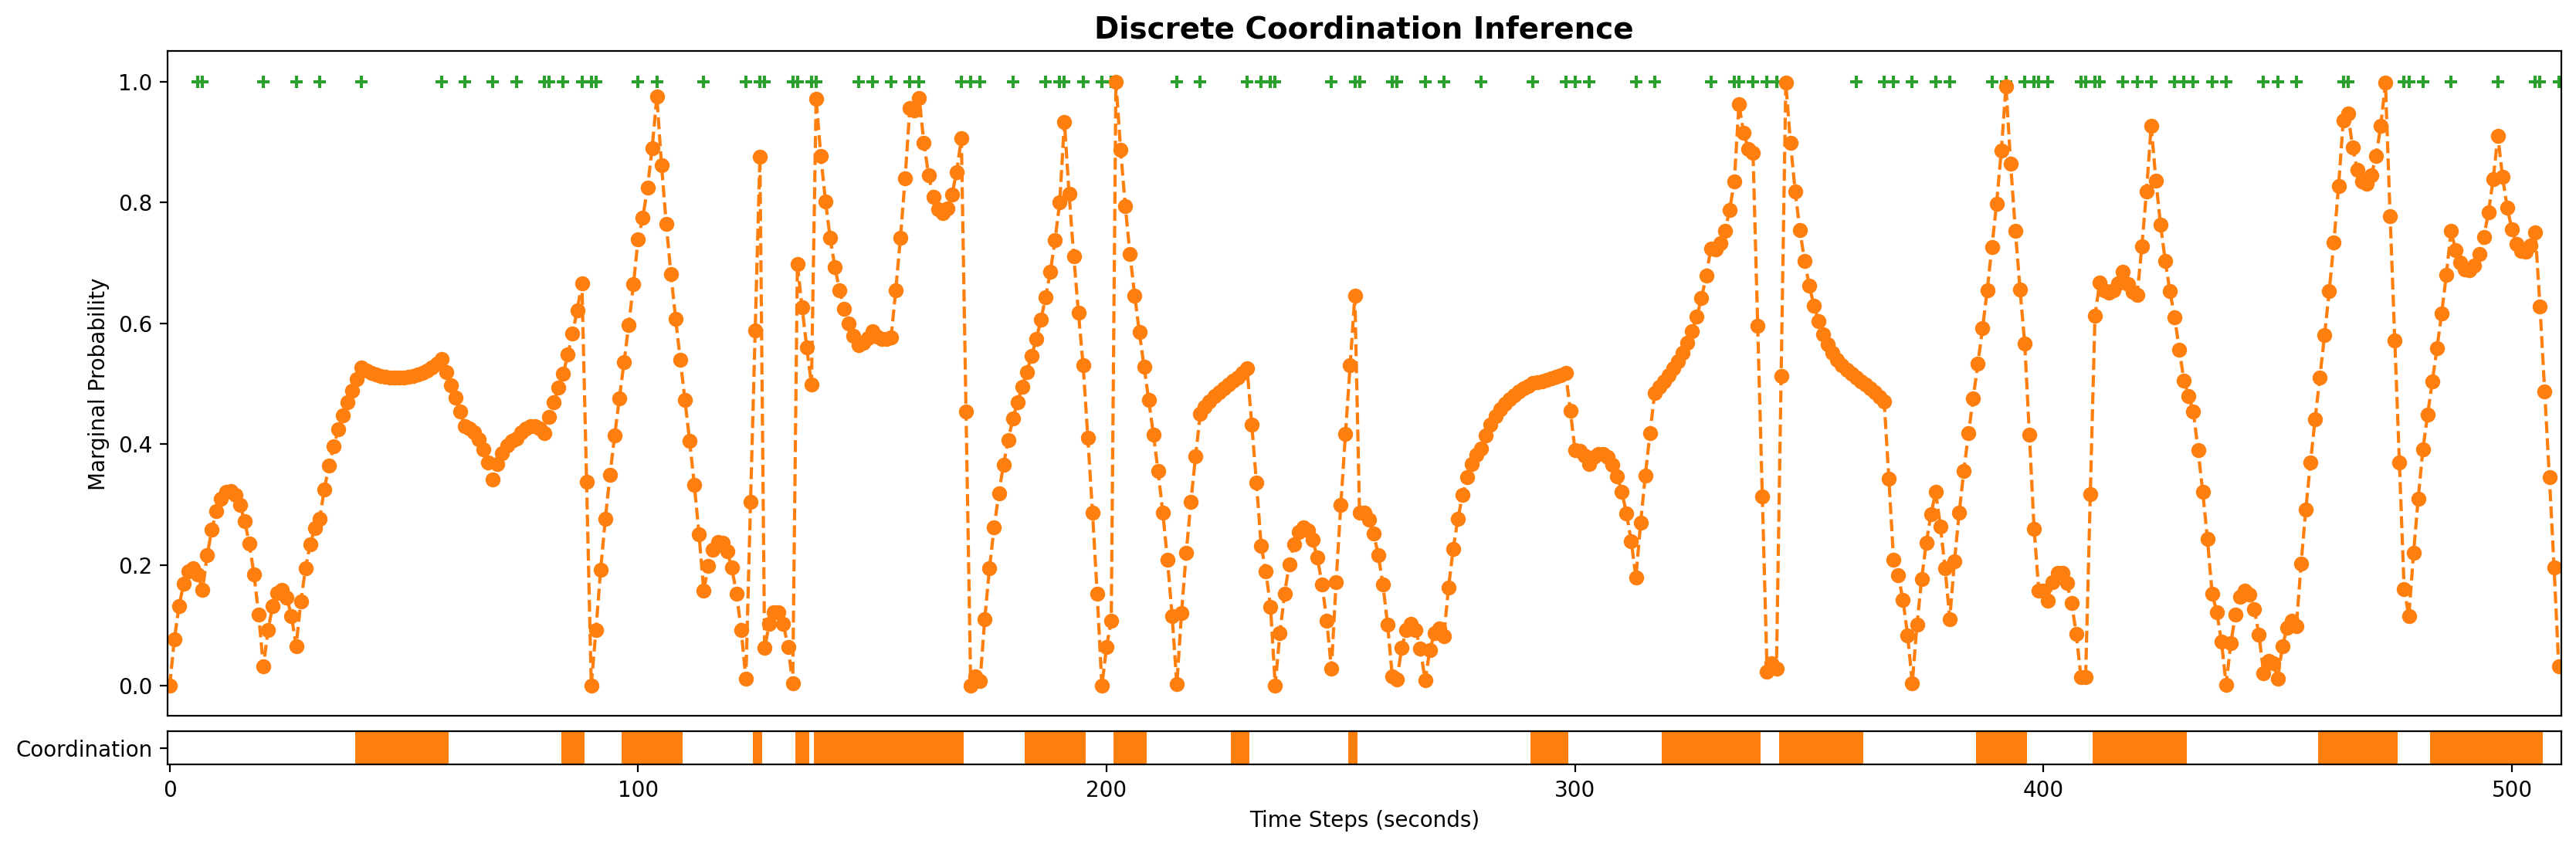

In [41]:
inference_engine = DiscreteCoordinationInferenceFromVocalics(vocalic_series=vocalic_series, 
                                                             p_prior_coordination=P_COORDINATION, 
                                                             p_coordination_transition=P_COORDINATION_TRANSITION,
                                                             mean_prior_vocalics=MEAN_PRIOR_VOCALICS,
                                                             std_prior_vocalics=STD_PRIOR_VOCALICS,
                                                             std_uncoordinated_vocalics=STD_UNCOORDINATED_VOCALICS,
                                                             std_coordinated_vocalics=STD_COORDINATED_VOCALICS)
marginal_cs = inference_engine.estimate_means_and_variances()[0]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:orange", linestyle="--")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Marginal Probability")
plt.title("Discrete Coordination Inference", fontsize=14, weight="bold")
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(vocalic_series.mask) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(marginal_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

### Anti-Phase Coordination

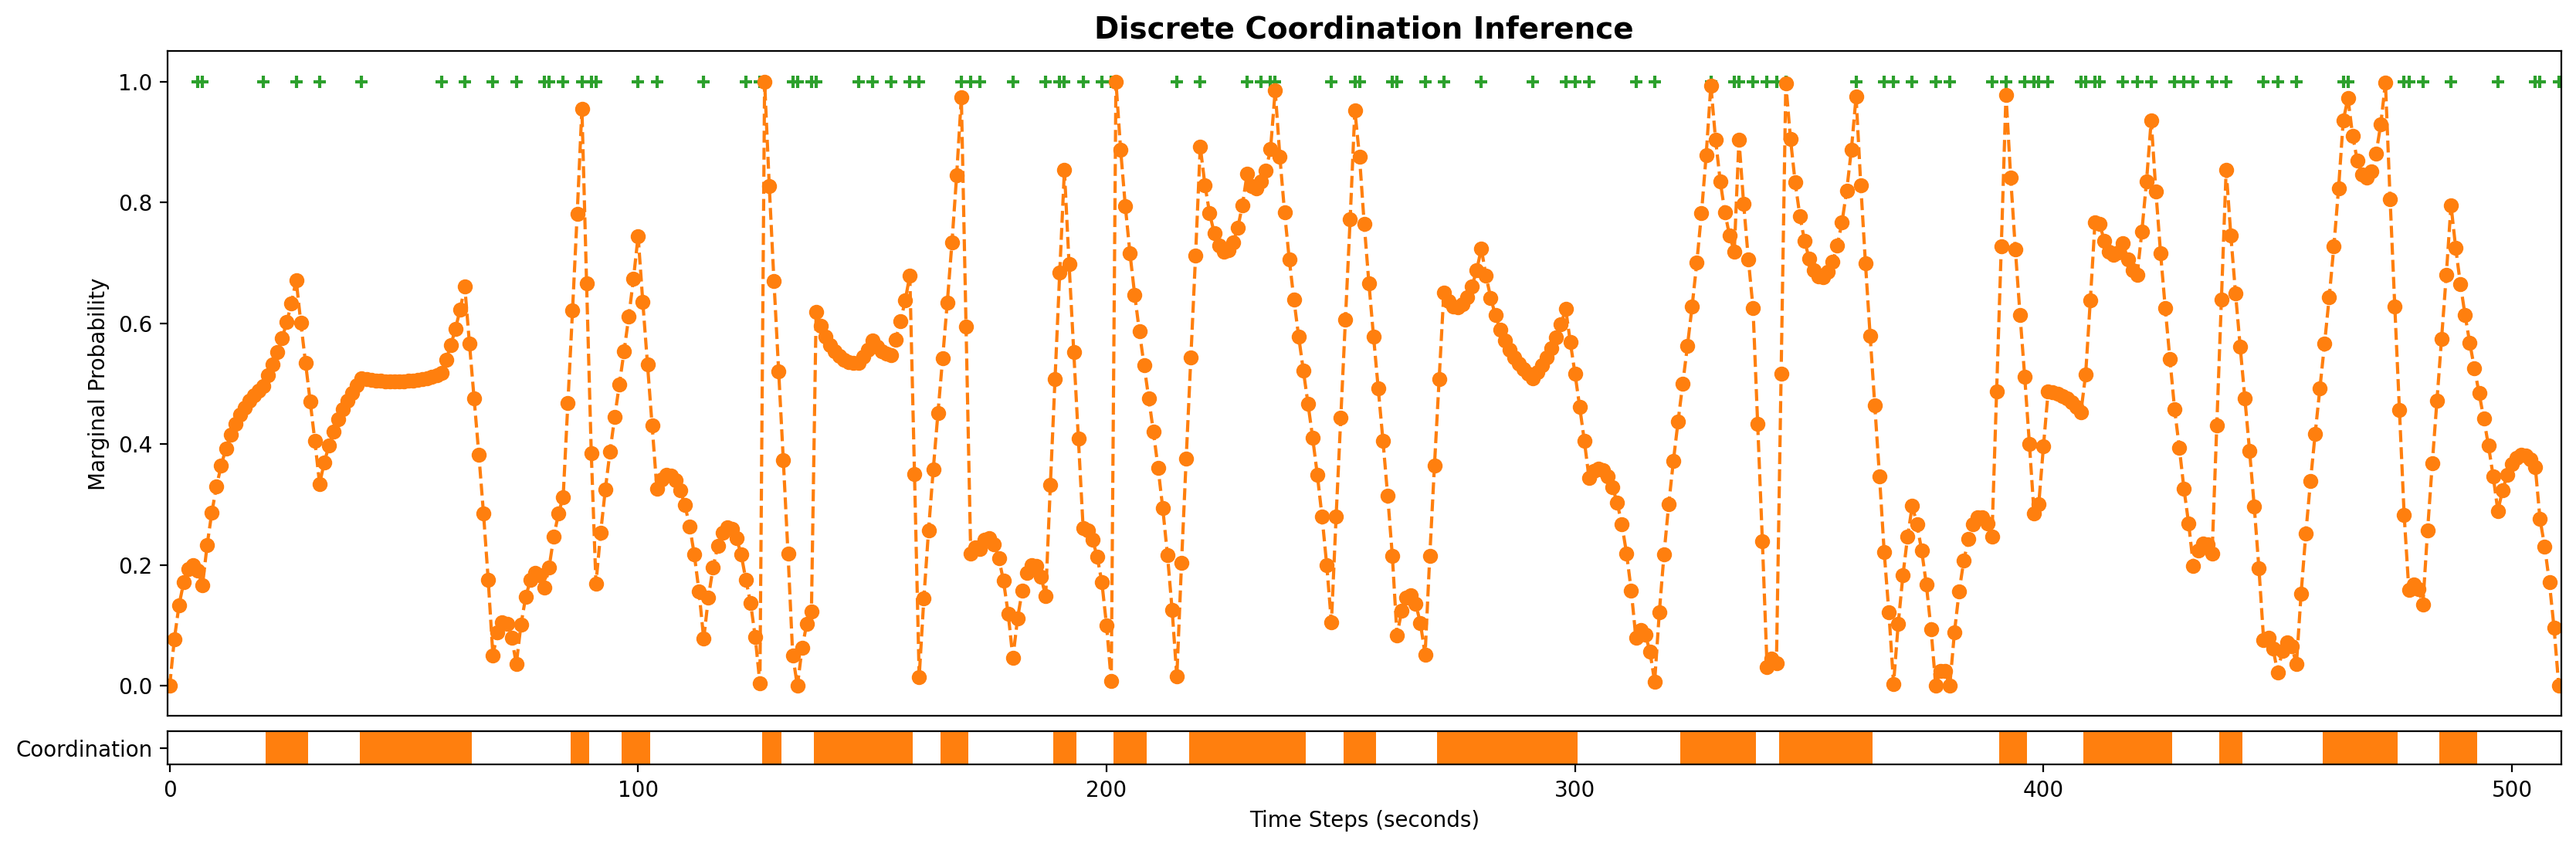

In [42]:
inference_engine = DiscreteCoordinationInferenceFromVocalics(vocalic_series=vocalic_series, 
                                                             p_prior_coordination=P_COORDINATION, 
                                                             p_coordination_transition=P_COORDINATION_TRANSITION,
                                                             mean_prior_vocalics=MEAN_PRIOR_VOCALICS,
                                                             std_prior_vocalics=STD_PRIOR_VOCALICS,
                                                             std_uncoordinated_vocalics=STD_UNCOORDINATED_VOCALICS,
                                                             std_coordinated_vocalics=STD_COORDINATED_VOCALICS,
                                                             f=ANTIPHASE_FUNCTION)
marginal_cs = inference_engine.estimate_means_and_variances()[0]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:orange", linestyle="--")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Marginal Probability")
plt.title("Discrete Coordination Inference", fontsize=14, weight="bold")
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(vocalic_series.mask) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(marginal_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

### Either-Phase Coordination

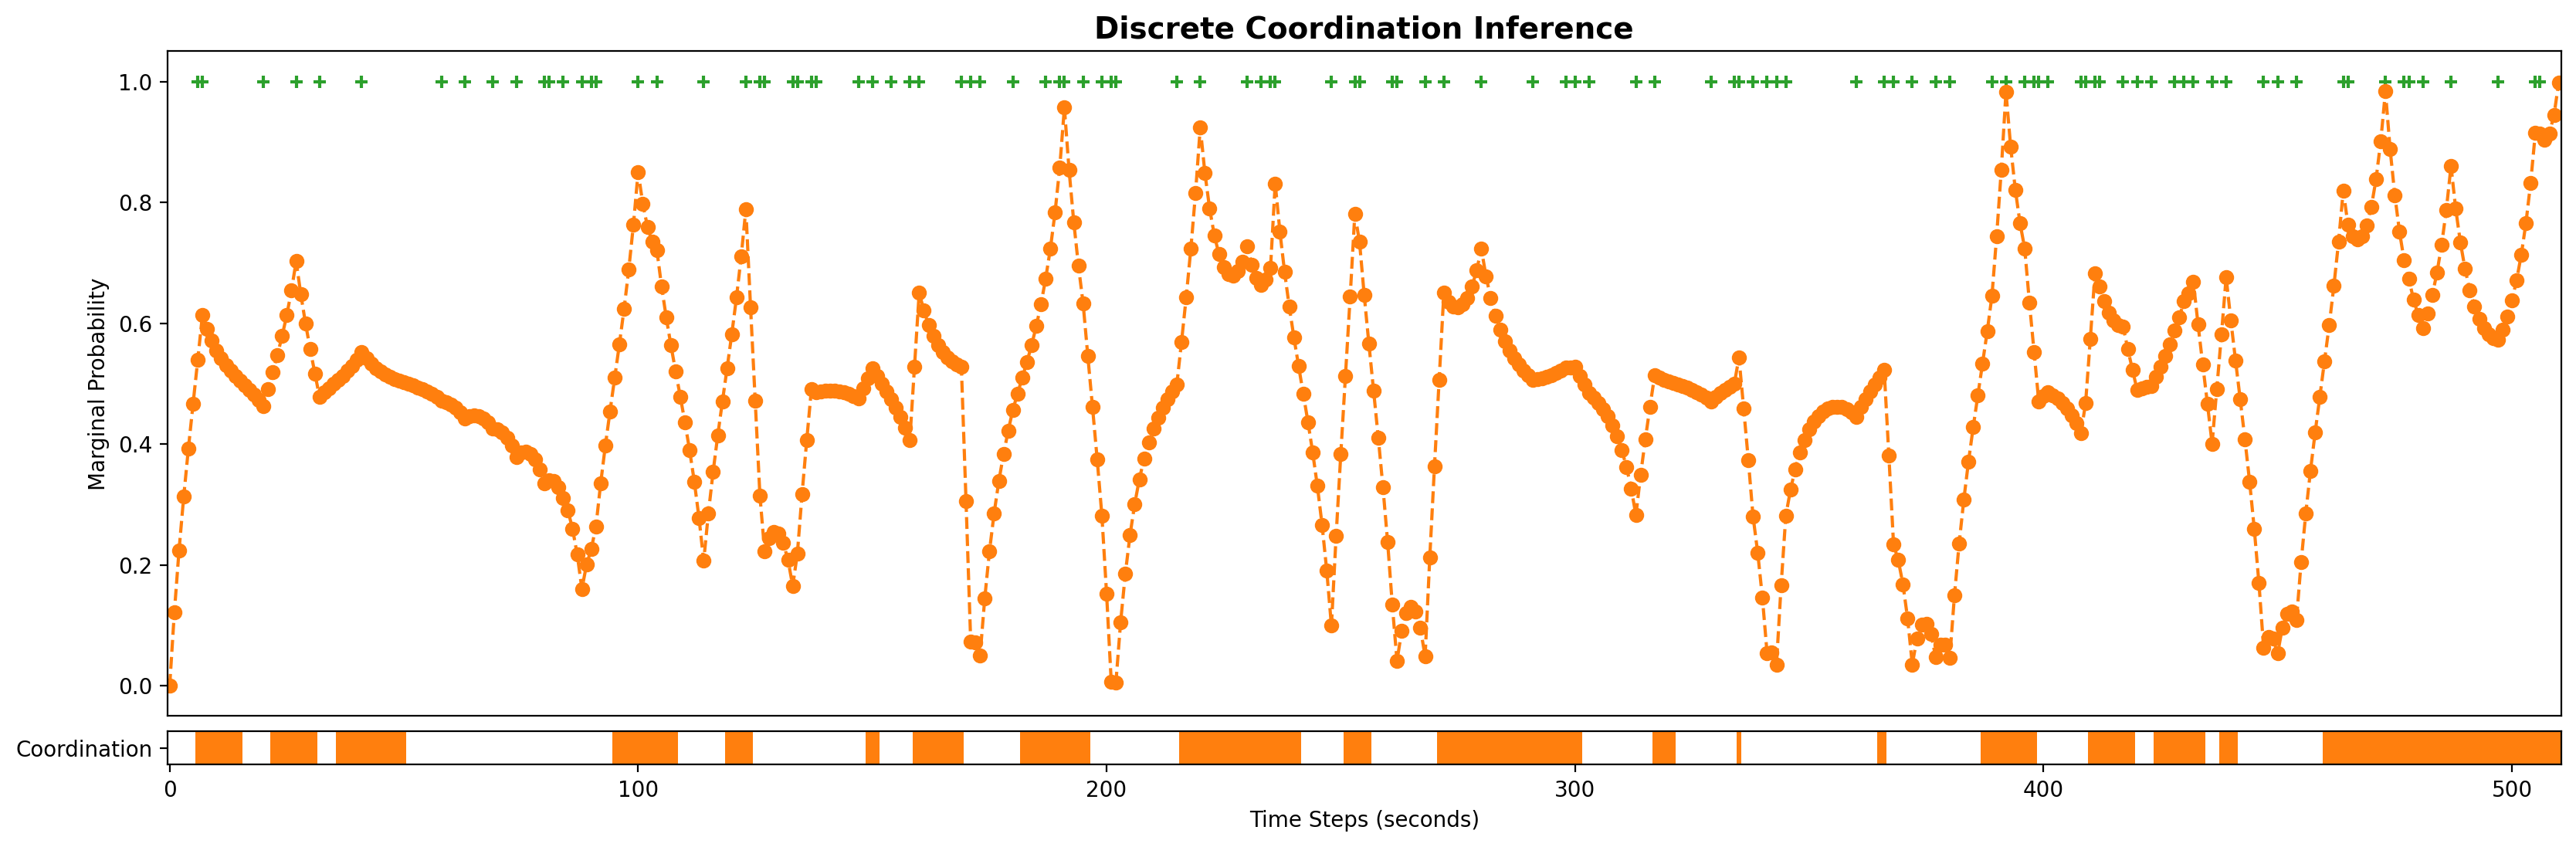

In [43]:
inference_engine = DiscreteCoordinationInferenceFromVocalics(vocalic_series=vocalic_series, 
                                                             p_prior_coordination=P_COORDINATION, 
                                                             p_coordination_transition=P_COORDINATION_TRANSITION,
                                                             mean_prior_vocalics=MEAN_PRIOR_VOCALICS,
                                                             std_prior_vocalics=STD_PRIOR_VOCALICS,
                                                             std_uncoordinated_vocalics=STD_UNCOORDINATED_VOCALICS,
                                                             std_coordinated_vocalics=STD_COORDINATED_VOCALICS,
                                                             f=EITHER_PHASE_FUNCTION)
marginal_cs = inference_engine.estimate_means_and_variances()[0]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:orange", linestyle="--")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Marginal Probability")
plt.title("Discrete Coordination Inference", fontsize=14, weight="bold")
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(vocalic_series.mask) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(marginal_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

## Gaussian Coordination Inference

### Phase Coordination

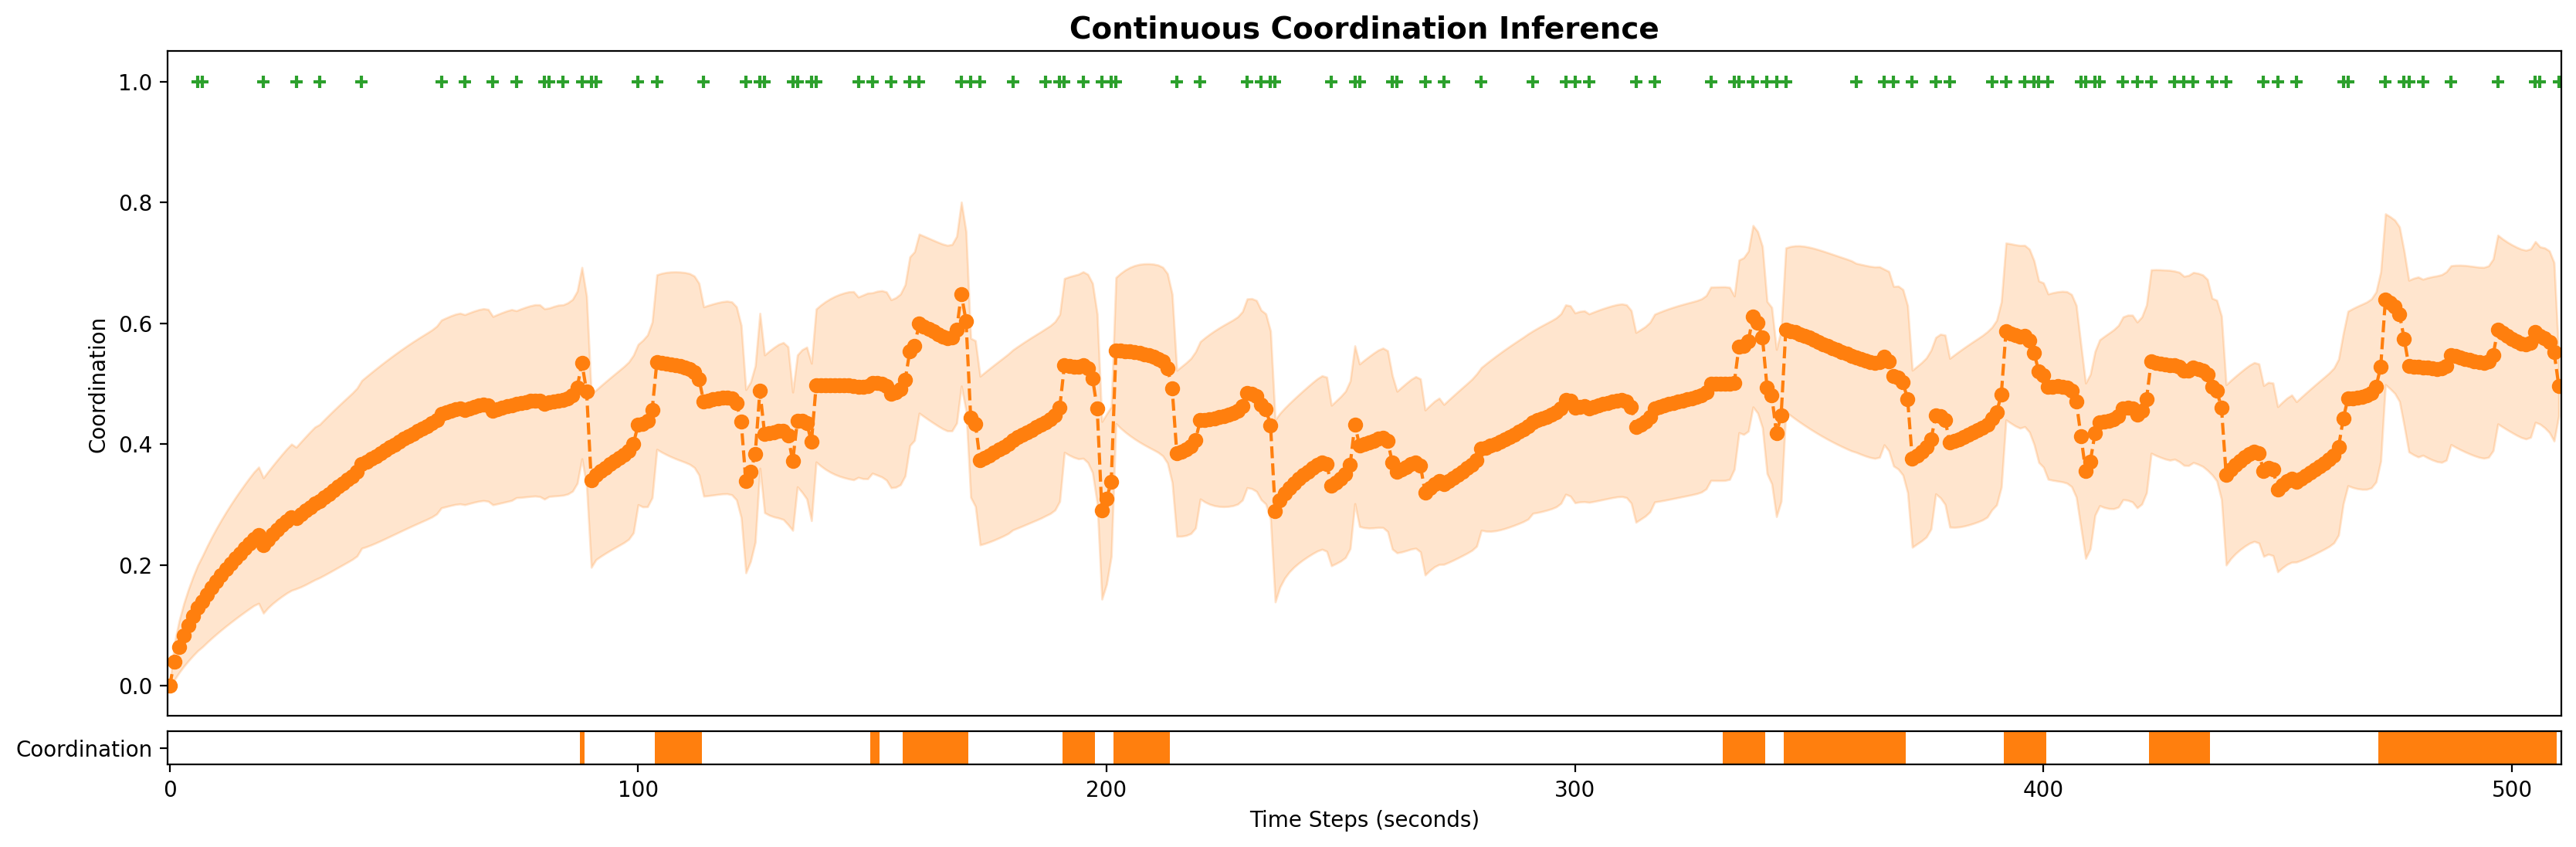

In [44]:
inference_engine = TruncatedGaussianCoordinationBlendingInference(vocalic_series=vocalic_series,
                                                               mean_prior_coordination=MEAN_COORDINATION_PRIOR,
                                                               std_prior_coordination=STD_COORDINATION_PRIOR, 
                                                               std_coordination_drifting=STD_COORDINATION_DRIFT,
                                                               mean_prior_vocalics=MEAN_PRIOR_VOCALICS,
                                                               std_prior_vocalics=STD_PRIOR_VOCALICS,
                                                               std_coordinated_vocalics=STD_COORDINATED_VOCALICS)
params = inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(vocalic_series.mask) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination")
plt.title("Continuous Coordination Inference", fontsize=14, weight="bold")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(mean_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

#### Coordination Change Report

In [45]:
# trial_audio = TrialAudio(trial.metadata, "/Users/paulosoares/data/study-3_2022/tomcat_agent/audio")
# report = CoordinationChangeReport(mean_cs, vocalic_series, trial_audio, "Trial: T00045")
# report.export_to_html("../data/study-3_2022/tomcat_agent/trials/T000745/coordination_change/continuous_in_phase_report.html", 0.25)

### Anti-Phase Coordination

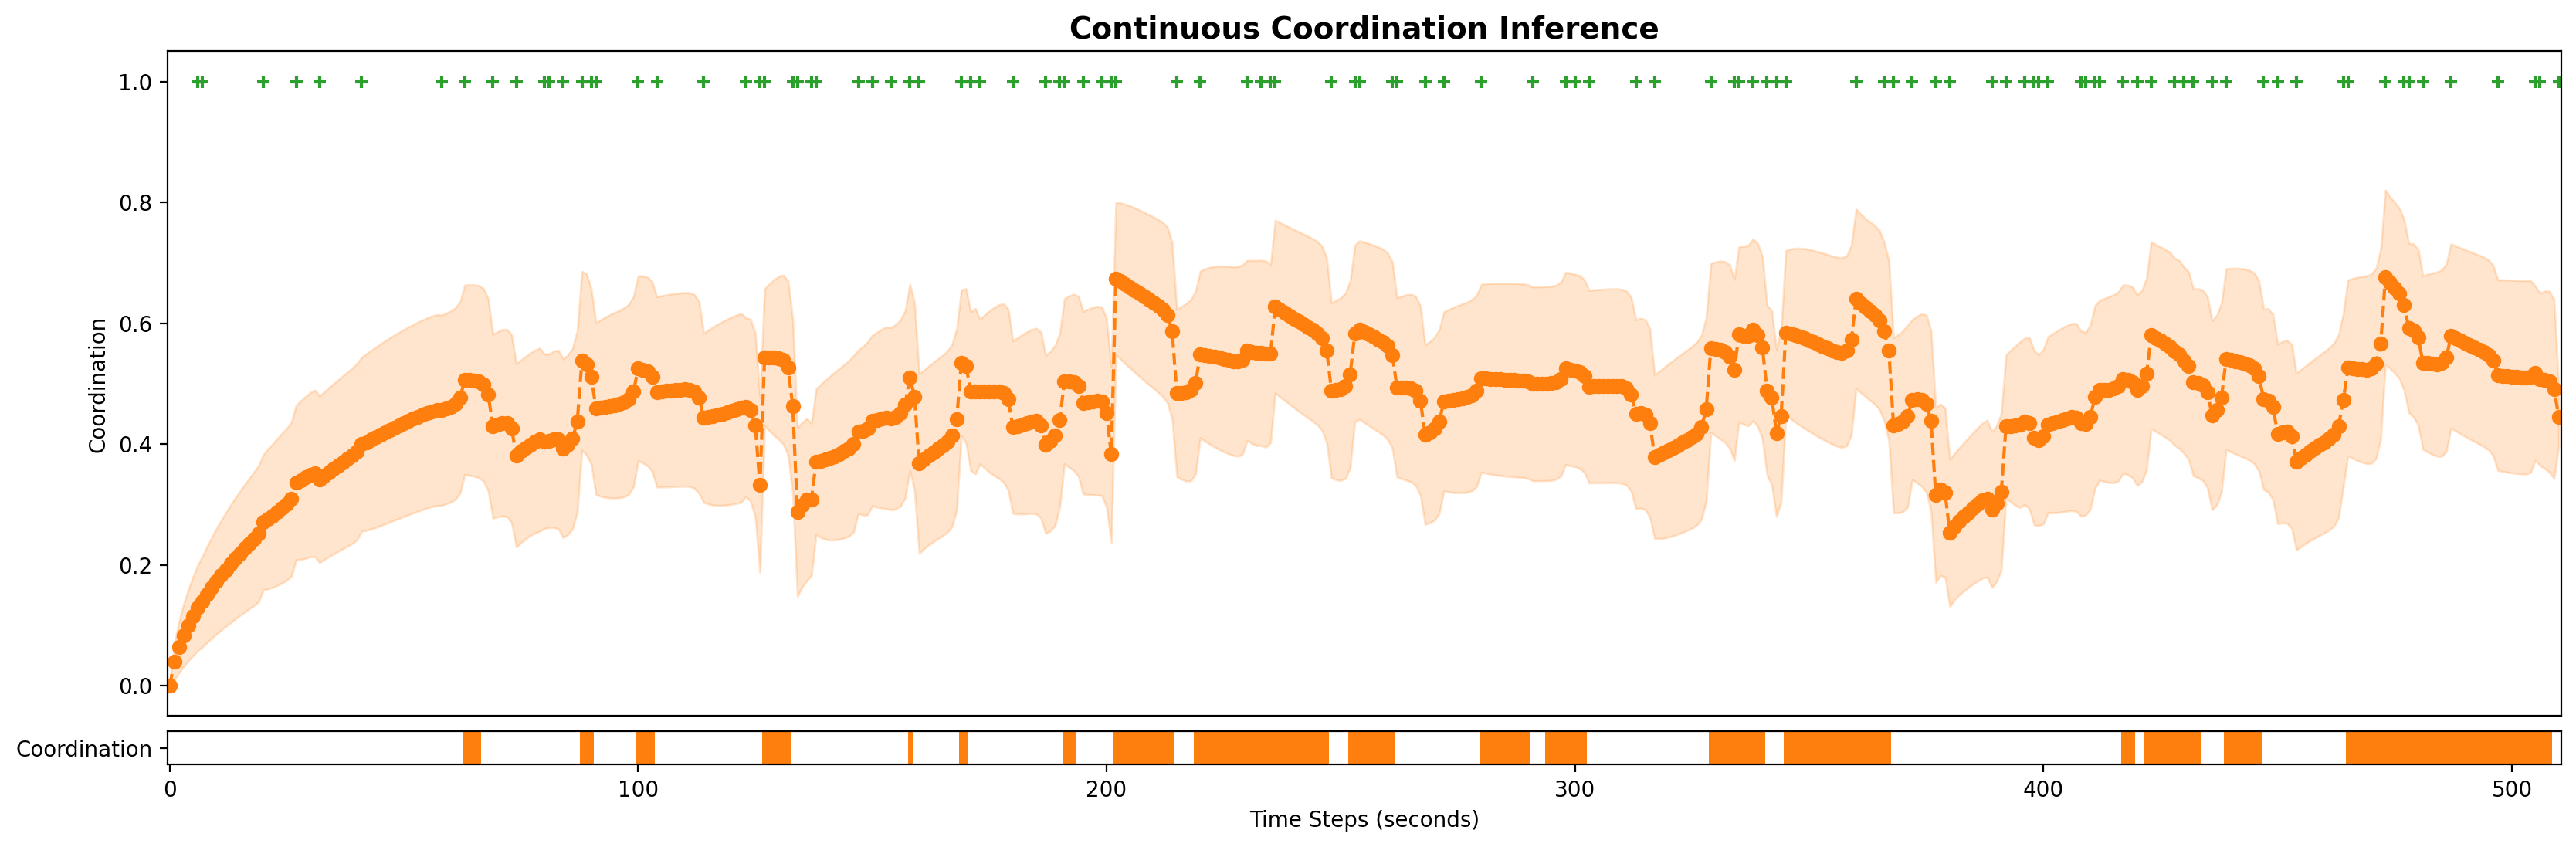

In [46]:
inference_engine = TruncatedGaussianCoordinationBlendingInference(vocalic_series=vocalic_series,
                                                               mean_prior_coordination=MEAN_COORDINATION_PRIOR,
                                                               std_prior_coordination=STD_COORDINATION_PRIOR, 
                                                               std_coordination_drifting=STD_COORDINATION_DRIFT,
                                                               mean_prior_vocalics=MEAN_PRIOR_VOCALICS,
                                                               std_prior_vocalics=STD_PRIOR_VOCALICS,
                                                               std_coordinated_vocalics=STD_COORDINATED_VOCALICS,
                                                               f=ANTIPHASE_FUNCTION)
params = inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(vocalic_series.mask) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination")
plt.title("Continuous Coordination Inference", fontsize=14, weight="bold")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(mean_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

### Either-phase Coordination

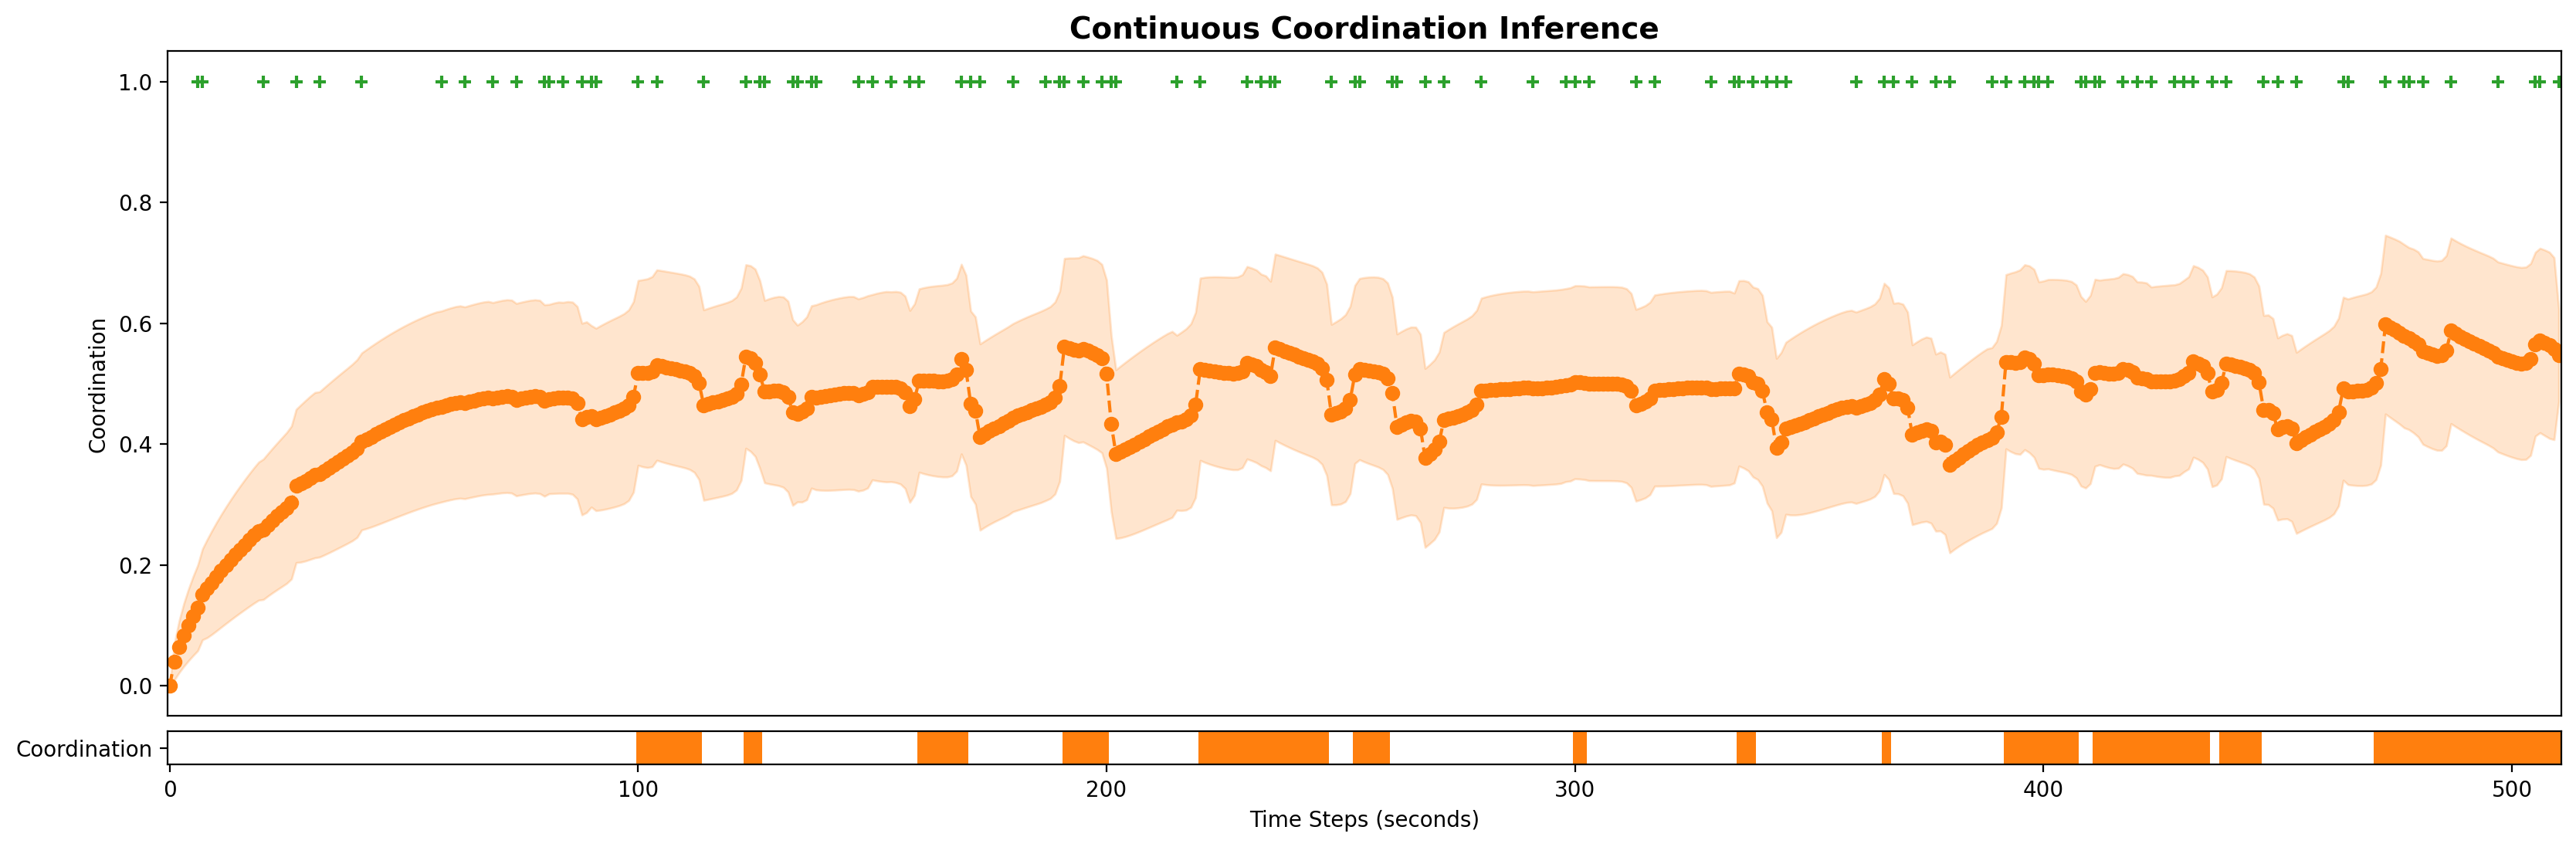

In [47]:
inference_engine = TruncatedGaussianCoordinationBlendingInference(vocalic_series=vocalic_series,
                                                               mean_prior_coordination=MEAN_COORDINATION_PRIOR,
                                                               std_prior_coordination=STD_COORDINATION_PRIOR, 
                                                               std_coordination_drifting=STD_COORDINATION_DRIFT,
                                                               mean_prior_vocalics=MEAN_PRIOR_VOCALICS,
                                                               std_prior_vocalics=STD_PRIOR_VOCALICS,
                                                               std_coordinated_vocalics=STD_COORDINATED_VOCALICS,
                                                               f=EITHER_PHASE_FUNCTION)
params = inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(vocalic_series.mask) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination")
plt.title("Continuous Coordination Inference", fontsize=14, weight="bold")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(mean_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

## Gaussian Coordination Inference with Latent Vocalics

### Anti-Phase Coordination

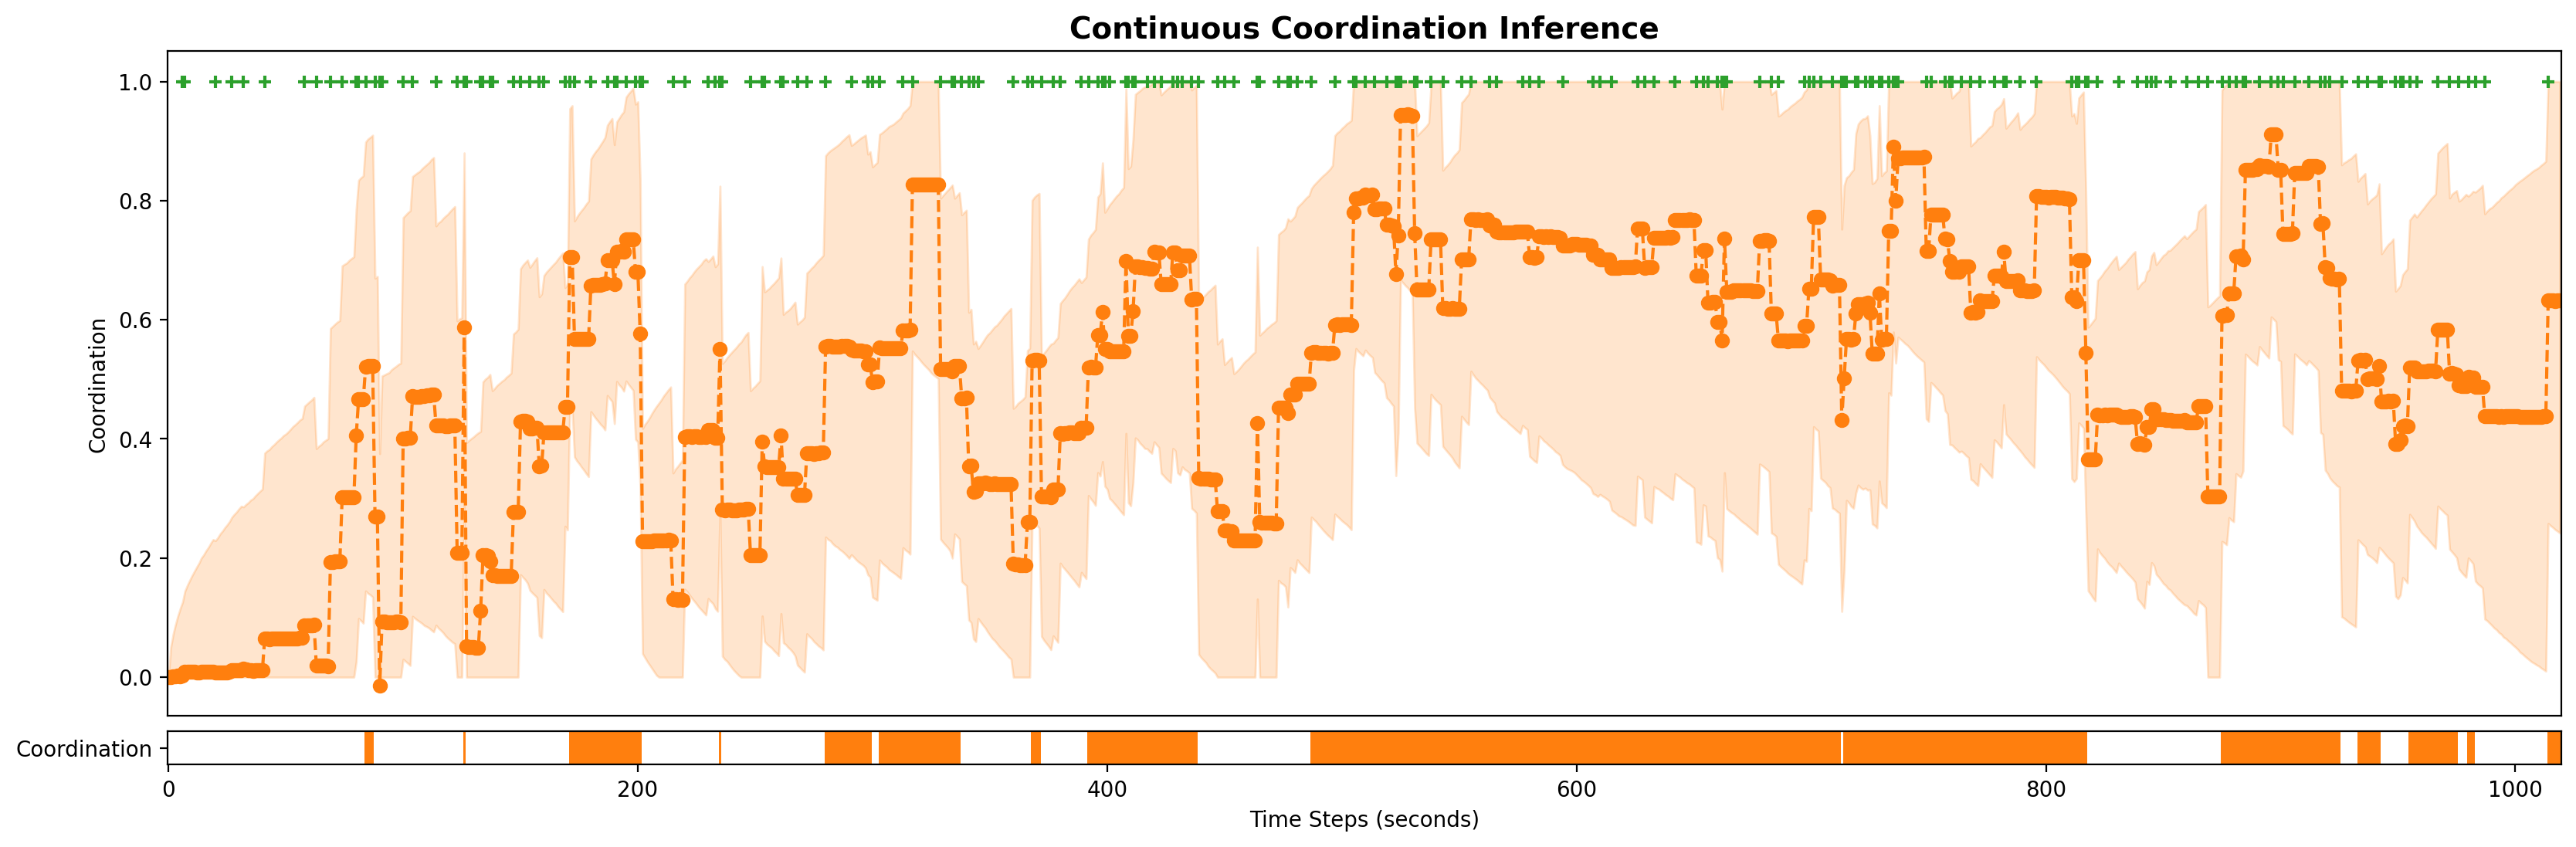

In [53]:
inference_engine = GaussianCoordinationBlendingInferenceLatentVocalics(vocalic_series=vocalic_series,
                                                                                mean_prior_coordination=MEAN_COORDINATION_PRIOR,
                                                                                std_prior_coordination=STD_COORDINATION_PRIOR, 
                                                                                std_coordination_drifting=STD_COORDINATION_DRIFT,
                                                                                mean_prior_latent_vocalics=MEAN_PRIOR_VOCALICS,
                                                                                std_prior_latent_vocalics=STD_PRIOR_VOCALICS,
                                                                                std_coordinated_latent_vocalics=STD_COORDINATED_VOCALICS,
                                                                                std_observed_vocalics=STD_OBSERVED_VOCALICS,
                                                                                num_particles=10000,
                                                                                f=ANTIPHASE_FUNCTION,
                                                                                fix_coordination_on_second_half=False)
params = inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(NUM_TIME_STEPS), mean_cs, marker="o", color="tab:orange", linestyle="--")
plt.fill_between(range(NUM_TIME_STEPS), np.clip(mean_cs - np.sqrt(var_cs), a_min=0, a_max=1), np.clip(mean_cs + np.sqrt(var_cs), a_min=0, a_max=1), color='tab:orange', alpha=0.2)
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(vocalic_series.mask) if mask > 0]))
plt.scatter(times, masks, color="tab:green", marker="+")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination")
plt.title("Continuous Coordination Inference", fontsize=14, weight="bold")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(mean_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

Text(0.5, 1.0, 'Continuous Coordination Inference')

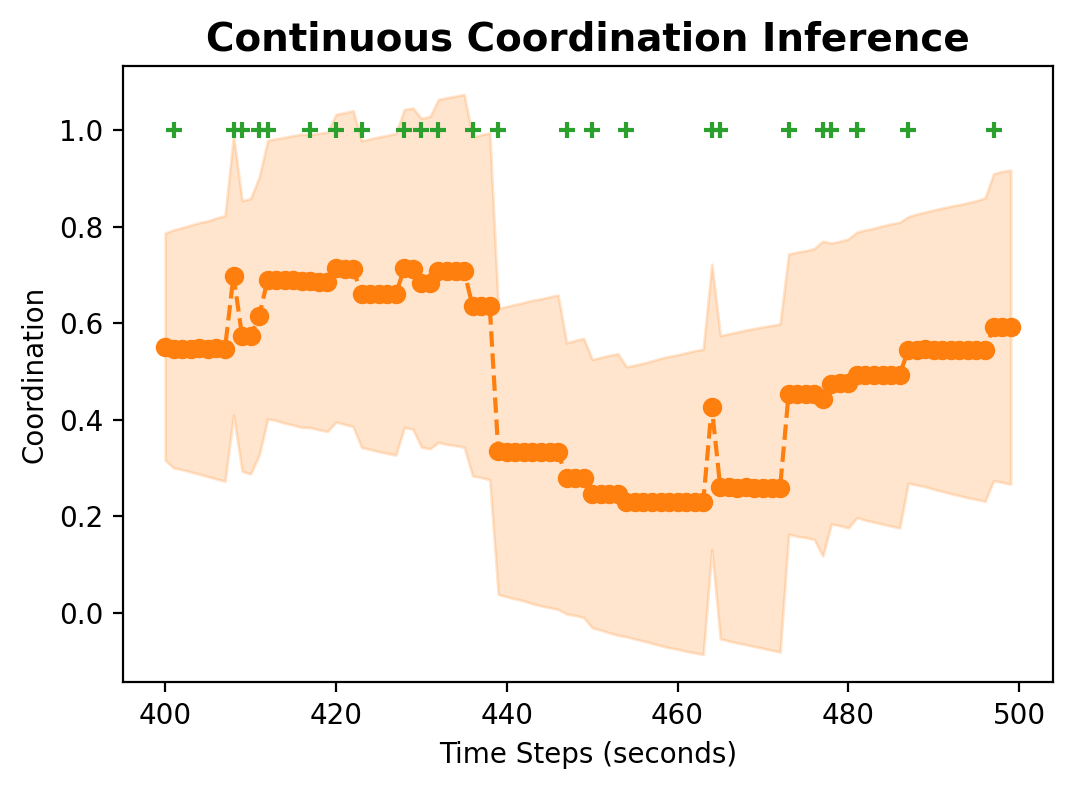

In [54]:
fig = plt.figure(figsize=(6, 4))
plt.plot(range(400,500), mean_cs[400:500], marker="o", color="tab:orange", linestyle="--")
plt.fill_between(range(400,500), mean_cs[400:500] - np.sqrt(var_cs[400:500]), mean_cs[400:500] + np.sqrt(var_cs[400:500]), color='tab:orange', alpha=0.2)
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(vocalic_series.mask) if mask > 0 and t >= 400 and t < 500]))
plt.scatter(times, masks, color="tab:green", marker="+")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination")
plt.title("Continuous Coordination Inference", fontsize=14, weight="bold")

In [56]:
np.clip(4.5, a_min=0, a_max=2)

2.0